# Dataset 2 - Friedman 1

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE Logit Loss to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is linear. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import friedman1Dataset
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

In [4]:
# Parameters
n_samples = 10
n_features = 10
mean = 0
variance = 1


## Dataset

Friedman 1 Dataset 

*   $y(X) = 10 * sin(pi * X_0 * X_1) + 20 * (X_2 - 0.5) ** 2 + 10 * X_3 + 5 * X_4 + noise * N(0, 1)$.
* Only 5 features used to calculate y 
* Noise is Gaussian 
* 1000 datapoints and 10 features used in the following experiment 

In [5]:
X, Y = friedman1Dataset.friedman1_data(n_samples,n_features)

         X0        X1        X2        X3        X4        X5        X6  \
0  0.337282  0.492560  0.059750  0.107833  0.749922  0.856076  0.185971   
1  0.053094  0.115243  0.814209  0.427034  0.148056  0.491381  0.930201   
2  0.902983  0.613198  0.421285  0.311578  0.177724  0.996704  0.414746   
3  0.786161  0.418738  0.691431  0.755136  0.986698  0.709631  0.407543   
4  0.705761  0.485958  0.610054  0.273739  0.894464  0.341664  0.648280   

         X7        X8        X9          Y  
0  0.481825  0.193424  0.785997  13.787266  
1  0.428408  0.510133  0.460032   7.217794  
2  0.775501  0.439168  0.861509  13.939226  
3  0.783872  0.061824  0.026320  21.858223  
4  0.947963  0.463514  0.886867  16.364805  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                nan
Time:                        19:58:18   Log-Likelihood:                 328.38
No. Observations:                  10   AIC:                            -636.8
Df Residuals:                       0   BIC:                            -633.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.062e-15        inf          0        n

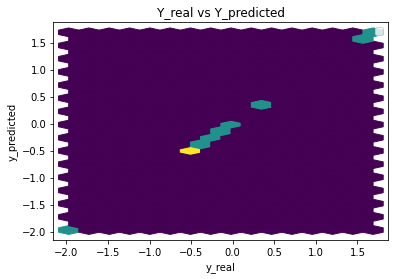

Performance Metrics
Mean Squared Error: 1.7587977438133117e-30
Mean Absolute Error: 9.131584377541912e-16
Manhattan distance: 9.131584377541913e-15
Euclidean distance: 4.193802265025512e-15


In [6]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [7]:
n_epochs = 5000
error = 0.001
batch_size = n_samples//2

## GAN Model

In [8]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Training GAN for n_epochs number of epochs** 

In [9]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


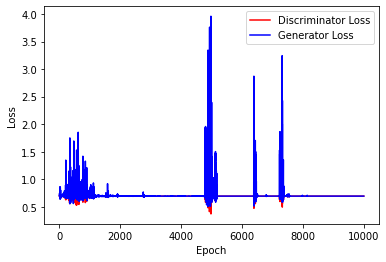

In [11]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

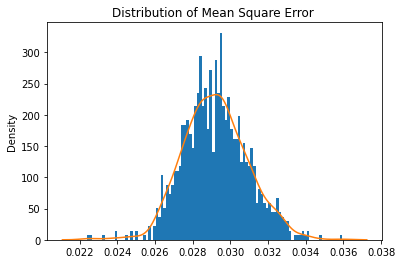

Mean Square Error: 0.029212660804415938


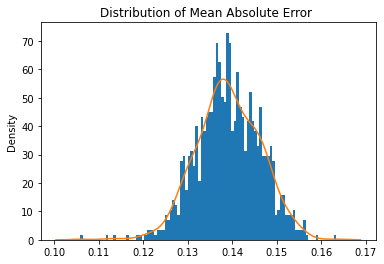

Mean Absolute Error: 0.1390935162499547


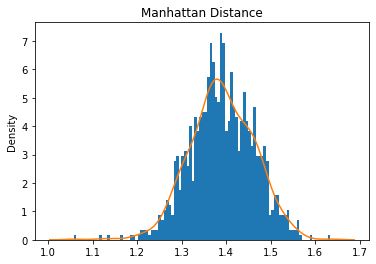

Mean Manhattan Distance: 1.390935162499547


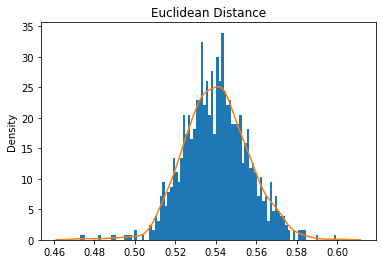

Mean Euclidean Distance: 0.5402554011539817


In [12]:
train_test.test_generator(generator,real_dataset,device)

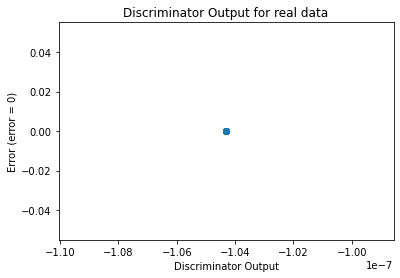

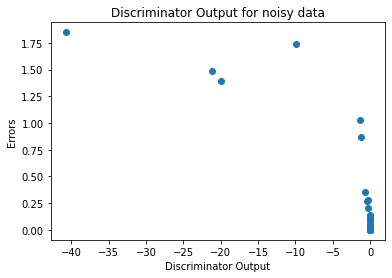

In [13]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [14]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)
criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs needed 677


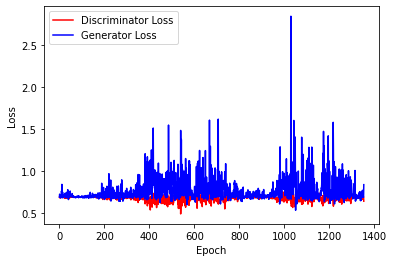

In [15]:
train_test.training_GAN_2(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size,error,criterion,device)

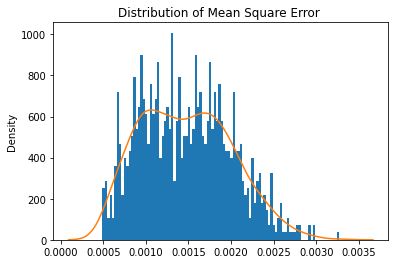

Mean Square Error: 0.001472188132619443


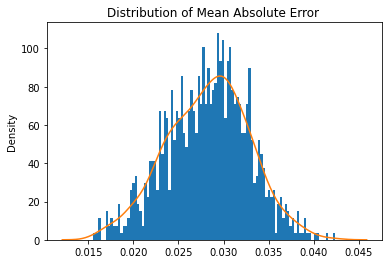

Mean Absolute Error: 0.028242639423906802


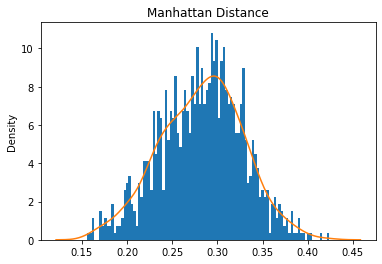

Mean Manhattan Distance: 0.282426394239068


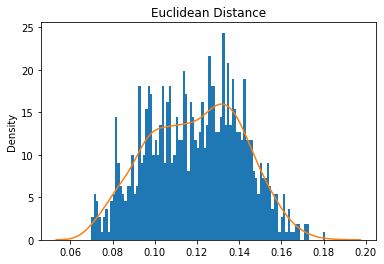

Mean Euclidean Distance: 0.11928945262810581


In [16]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [17]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

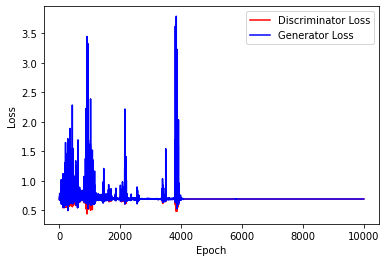

In [18]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

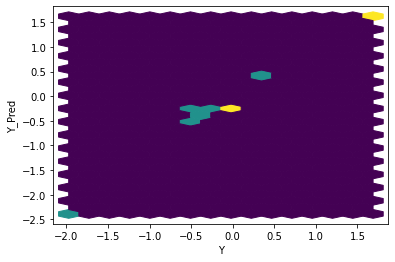

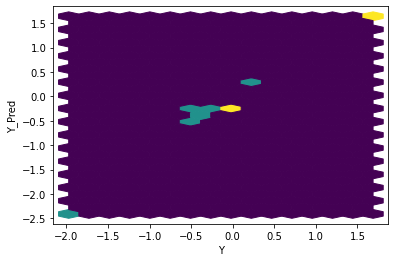

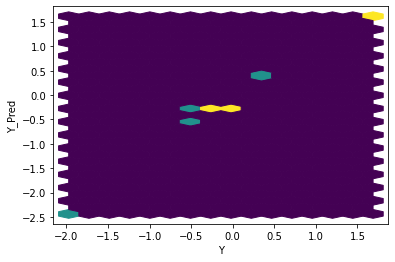

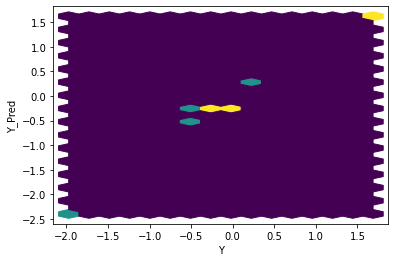

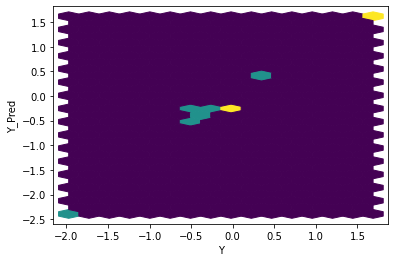

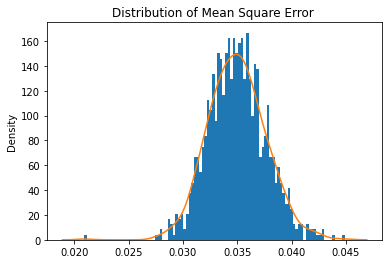

Mean Square Error: 0.03496890972943749


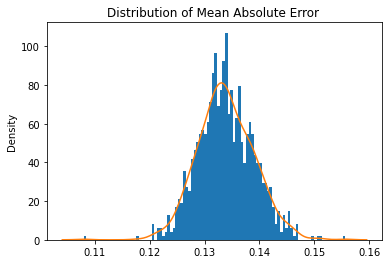

Mean Absolute Error: 0.13388840553164483
Mean Manhattan Distance: 1.3388840553164483


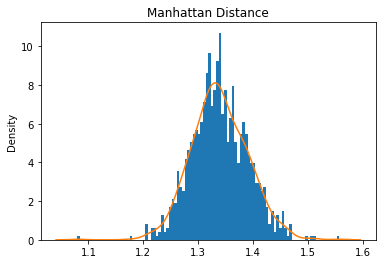

Mean Euclidean Distance: 0.5909191336055899


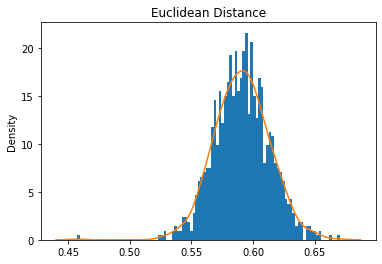

In [19]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

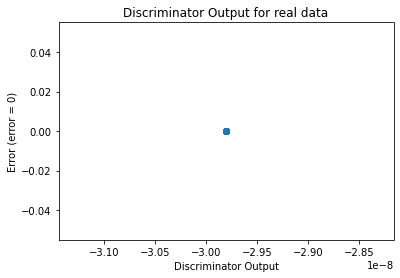

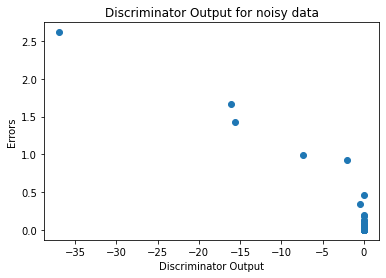

In [20]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [21]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs 490


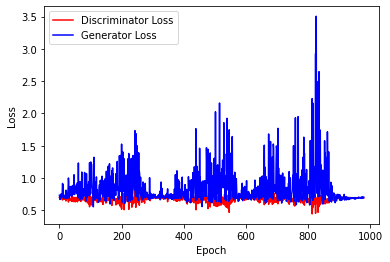

In [22]:
ABC_train_test.training_GAN_2(disc,gen,disc_opt,gen_opt,real_dataset,batch_size, error,criterion,coeff,mean,variance,device)

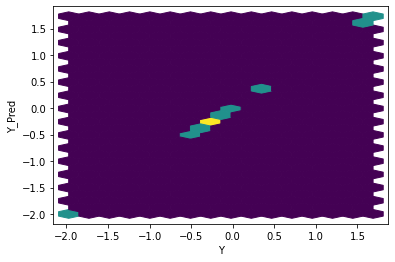

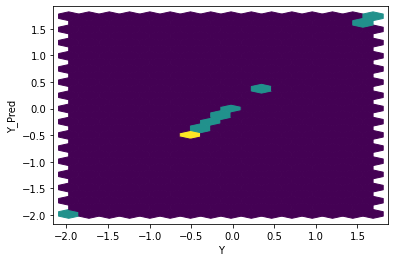

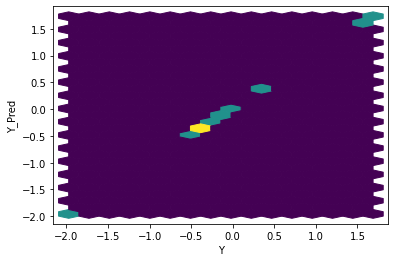

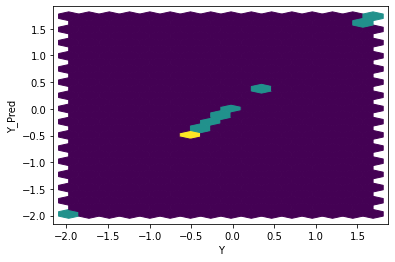

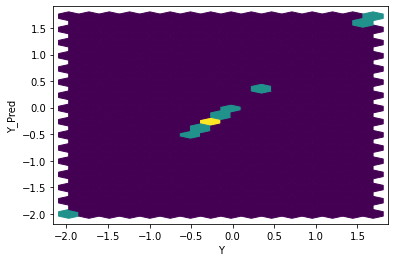

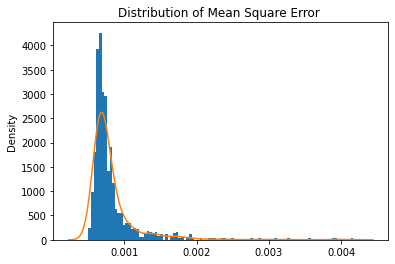

Mean Square Error: 0.0008210728827523836


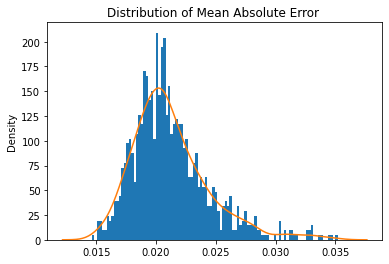

Mean Absolute Error: 0.021220456639677285
Mean Manhattan Distance: 0.21220456639677285


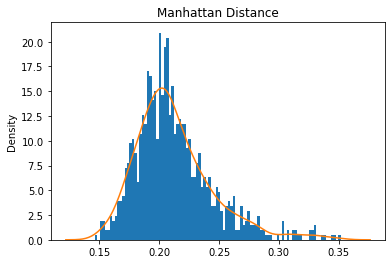

Mean Euclidean Distance: 0.08925664402277365


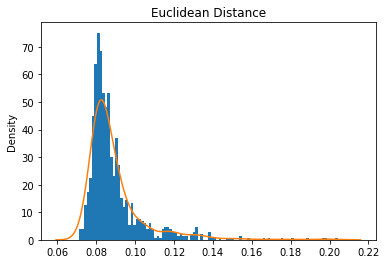

In [23]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)